<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**
Чем больше batch_size тем плавнее градиентный спуск, но нужно больше памяти


Посмотрим на какую-нибудь картинку:

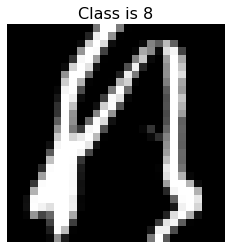

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [5]:
# Определим номера картинок для каждого класса и сохраним в переменные image:
for i in range(10):
    j = 0
    while trainset[j][1] != i:
        j += 1
    globals()["image"+str(i)] = trainset[j][0].view(28, 28).numpy()

Text(0.5, 1.0, 'Class 9')

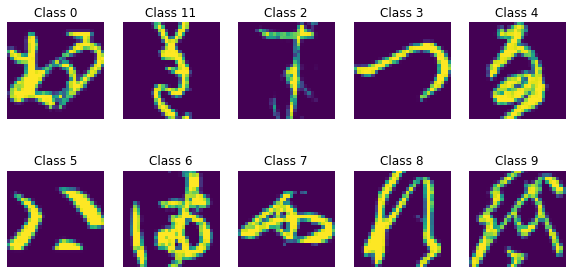

In [6]:
# Preparing subplot
fig = plt.figure(figsize=(10, 5))
rows = 2
columns = 5

# Ploting each image
fig.add_subplot(rows, columns, 1)
plt.imshow(image0)
plt.axis('off')
plt.title("Class 0")

fig.add_subplot(rows, columns, 2)
plt.imshow(image1)
plt.axis('off')
plt.title("Class 11")

fig.add_subplot(rows, columns, 3)
plt.imshow(image2)
plt.axis('off')
plt.title("Class 2")

fig.add_subplot(rows, columns, 4)
plt.imshow(image3)
plt.axis('off')
plt.title("Class 3")

fig.add_subplot(rows, columns, 5)
plt.imshow(image4)
plt.axis('off')
plt.title("Class 4")

fig.add_subplot(rows, columns, 6)
plt.imshow(image5)
plt.axis('off')
plt.title("Class 5")

fig.add_subplot(rows, columns, 7)
plt.imshow(image6)
plt.axis('off')
plt.title("Class 6")

fig.add_subplot(rows, columns, 8)
plt.imshow(image7)
plt.axis('off')
plt.title("Class 7")

fig.add_subplot(rows, columns, 9)
plt.imshow(image8)
plt.axis('off')
plt.title("Class 8")

fig.add_subplot(rows, columns, 10)
plt.imshow(image9)
plt.axis('off')
plt.title("Class 9")

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!

        self.fc1 = nn.Linear(in_features=28*28, out_features=256)

        self.fc2 = nn.Linear(in_features=256, out_features=128)

        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)


        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**


Количество обучаемых параметров можно вычислить несколькими способами: пользуясь встроенными функциями или по формуле: 

params = (input_features * output_features) + output_features



In [8]:
fc_net = FCNet()

In [9]:
sum(map(torch.numel, fc_net.parameters()))

235146

In [10]:
(28*28 * 256) + 256 + (256 * 128) + 128 + (128 * 10) + 10

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [11]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [12]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [13]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9239
Epoch=2 loss=0.4429
Epoch=3 loss=0.3457
Epoch=4 loss=0.2853
Epoch=5 loss=0.2434
Epoch=6 loss=0.2092
Epoch=7 loss=0.1835
Epoch=8 loss=0.1601
Epoch=9 loss=0.1420
Epoch=10 loss=0.1250


In [14]:
get_accuracy(fc_net, testloader)

0.8743

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [15]:
mean = 0.
std = 0.
for images, _ in trainloader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(trainloader.dataset)
std /= len(trainloader.dataset)
print(mean, std)

tensor([0.1918]) tensor([0.3385])


In [16]:
transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

In [17]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [18]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6884
Epoch=2 loss=0.3021
Epoch=3 loss=0.2255
Epoch=4 loss=0.1762
Epoch=5 loss=0.1404
Epoch=6 loss=0.1147
Epoch=7 loss=0.0932
Epoch=8 loss=0.0766
Epoch=9 loss=0.0622
Epoch=10 loss=0.0511


In [19]:
get_accuracy(fc_net, testloader)

0.8997

Как изменилась `accuracy` после нормализации?

**увеличилась**

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

**Создание нейросети с sigmoid активацией**

In [20]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!

        self.fc1 = nn.Linear(in_features=28*28, out_features=256)

        self.fc2 = nn.Linear(in_features=256, out_features=128)

        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)


        return x

In [21]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001 
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [22]:
%%time
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.5350
Epoch=2 loss=0.7365
Epoch=3 loss=0.5328
Epoch=4 loss=0.4370
Epoch=5 loss=0.3706
Epoch=6 loss=0.3191
Epoch=7 loss=0.2769
Epoch=8 loss=0.2431
Epoch=9 loss=0.2141
Epoch=10 loss=0.1890
Wall time: 2min 35s


In [23]:
get_accuracy(fc_net, testloader)

0.8522

**Создание нейросети с gelu активацией**

In [24]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!

        self.fc1 = nn.Linear(in_features=28*28, out_features=256)

        self.fc2 = nn.Linear(in_features=256, out_features=128)

        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        x = self.fc3(x)


        return x

In [25]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001 
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [26]:
%%time
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6634
Epoch=2 loss=0.2821
Epoch=3 loss=0.2032
Epoch=4 loss=0.1565
Epoch=5 loss=0.1229
Epoch=6 loss=0.0992
Epoch=7 loss=0.0783
Epoch=8 loss=0.0635
Epoch=9 loss=0.0508
Epoch=10 loss=0.0393
Wall time: 2min 38s


In [27]:
get_accuracy(fc_net, testloader)

0.9026

**Создание нейросети с tanh активацией**

In [28]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!

        self.fc1 = nn.Linear(in_features=28*28, out_features=256)

        self.fc2 = nn.Linear(in_features=256, out_features=128)

        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)


        return x

In [29]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001 
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [30]:
%%time
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.7765
Epoch=2 loss=0.3843
Epoch=3 loss=0.2570
Epoch=4 loss=0.1830
Epoch=5 loss=0.1354
Epoch=6 loss=0.1011
Epoch=7 loss=0.0755
Epoch=8 loss=0.0560
Epoch=9 loss=0.0411
Epoch=10 loss=0.0302
Wall time: 2min 37s


In [31]:
get_accuracy(fc_net, testloader)

0.9028

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

**tanh**

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

**Оптимизацию Adam мы использовали в предыдущем задании, получили accuracy 0.9028. Теперь попробуем RMSprop**

In [32]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!

        self.fc1 = nn.Linear(in_features=28*28, out_features=256)

        self.fc2 = nn.Linear(in_features=256, out_features=128)

        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)


        return x

In [33]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001 
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=3e-4)

In [34]:
%%time
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.5666
Epoch=2 loss=0.3110
Epoch=3 loss=0.2163
Epoch=4 loss=0.1580
Epoch=5 loss=0.1173
Epoch=6 loss=0.0880
Epoch=7 loss=0.0664
Epoch=8 loss=0.0486
Epoch=9 loss=0.0362
Epoch=10 loss=0.0266
Wall time: 2min 34s


In [35]:
get_accuracy(fc_net, testloader)

0.8905

**Попробуем Adagrad**

In [36]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001 
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)

In [37]:
%%time
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.3900
Epoch=2 loss=1.0091
Epoch=3 loss=0.8839
Epoch=4 loss=0.8133
Epoch=5 loss=0.7670
Epoch=6 loss=0.7327
Epoch=7 loss=0.7064
Epoch=8 loss=0.6849
Epoch=9 loss=0.6673
Epoch=10 loss=0.6522
Wall time: 2min 37s


In [38]:
get_accuracy(fc_net, testloader)

0.6756

**Наибольшая accuracy при Adam**

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [39]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x

        return x

In [40]:
def relu(x):
    x[x < 0] = 0
    return x

class CustomReLU(nn.Module):     
    def __init__(self):
        # Тут можно сделать многое: передавать число слоев, входных признаков и тд
        # но пока что ограничимся чем-то простым

        super().__init__() # Не нужно забывать про это, иначе ничего не сработает

        self.fc1 = nn.Linear(in_features=28*28, out_features=256)

        self.fc2 = nn.Linear(in_features=256, out_features=128)

        self.fc3 = nn.Linear(in_features=128, out_features=10)

    

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        x = relu(x)
        x = self.fc3(x)


        return x # logits

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [41]:
fc_net = CustomReLU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001 
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [42]:
n_epochs = 10

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    lhe = epoch_loss/len(trainloader)
    
    print(f"Epoch={epoch+1} loss={lhe:.4f}")

Epoch=1 loss=0.6818
Epoch=2 loss=0.3020
Epoch=3 loss=0.2216
Epoch=4 loss=0.1723
Epoch=5 loss=0.1379
Epoch=6 loss=0.1128
Epoch=7 loss=0.0918
Epoch=8 loss=0.0748
Epoch=9 loss=0.0608
Epoch=10 loss=0.0493


In [43]:
get_accuracy(fc_net, testloader)

0.8983

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

фиолетовая рыба

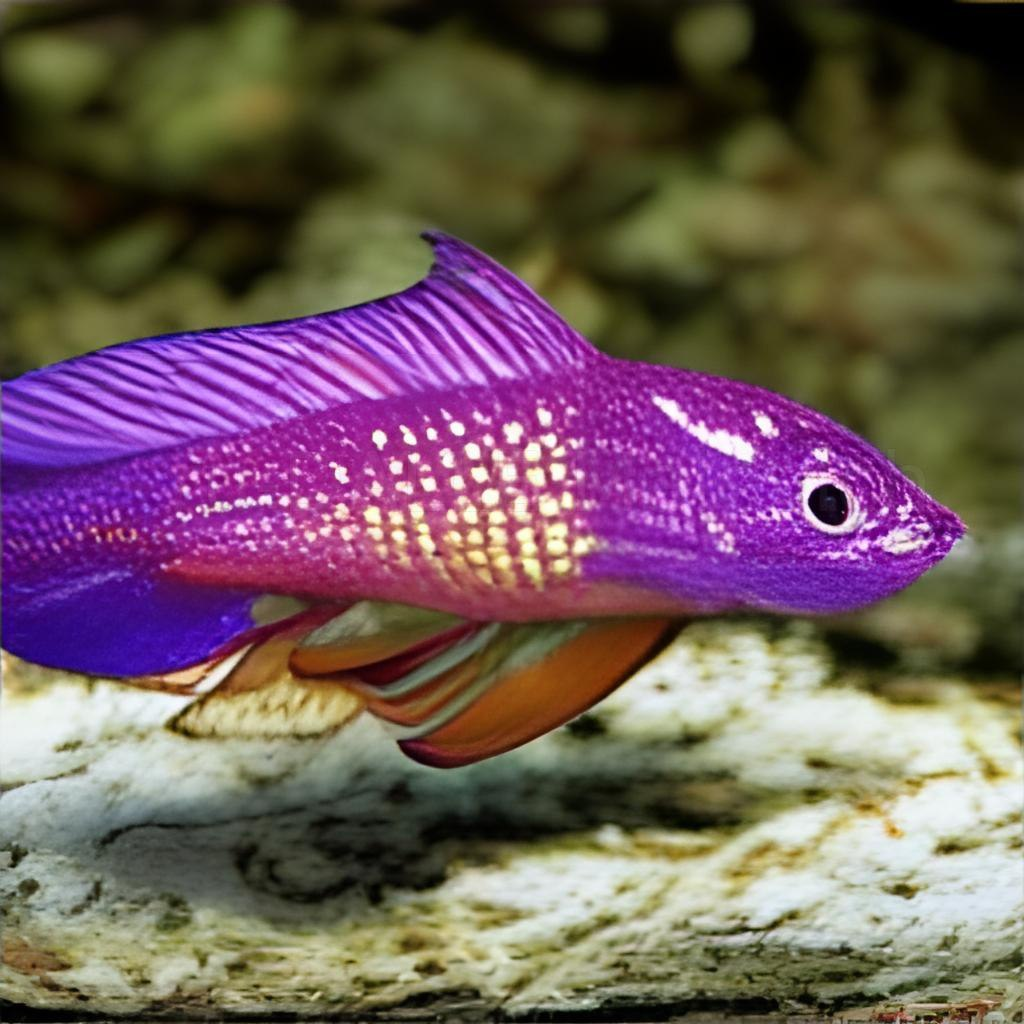

кот спит на солнце

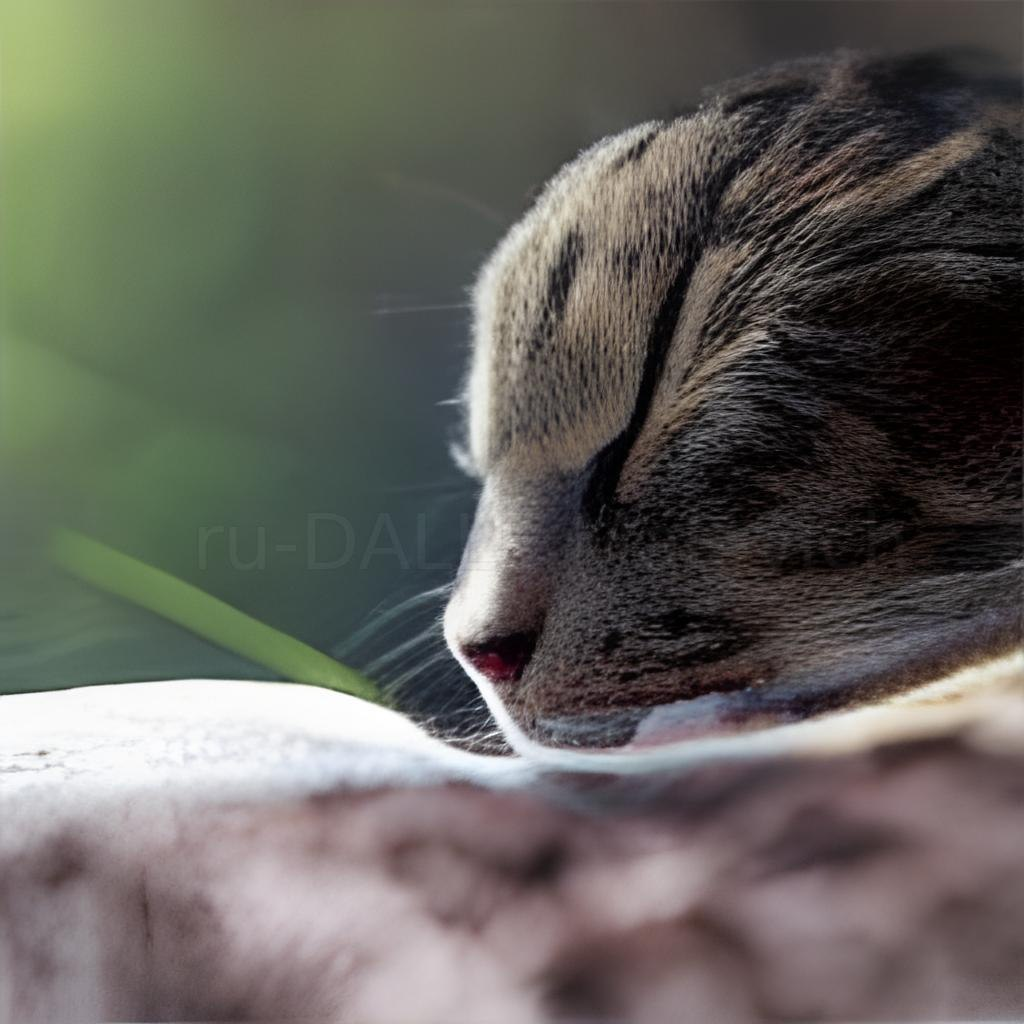

цифры едят кашу

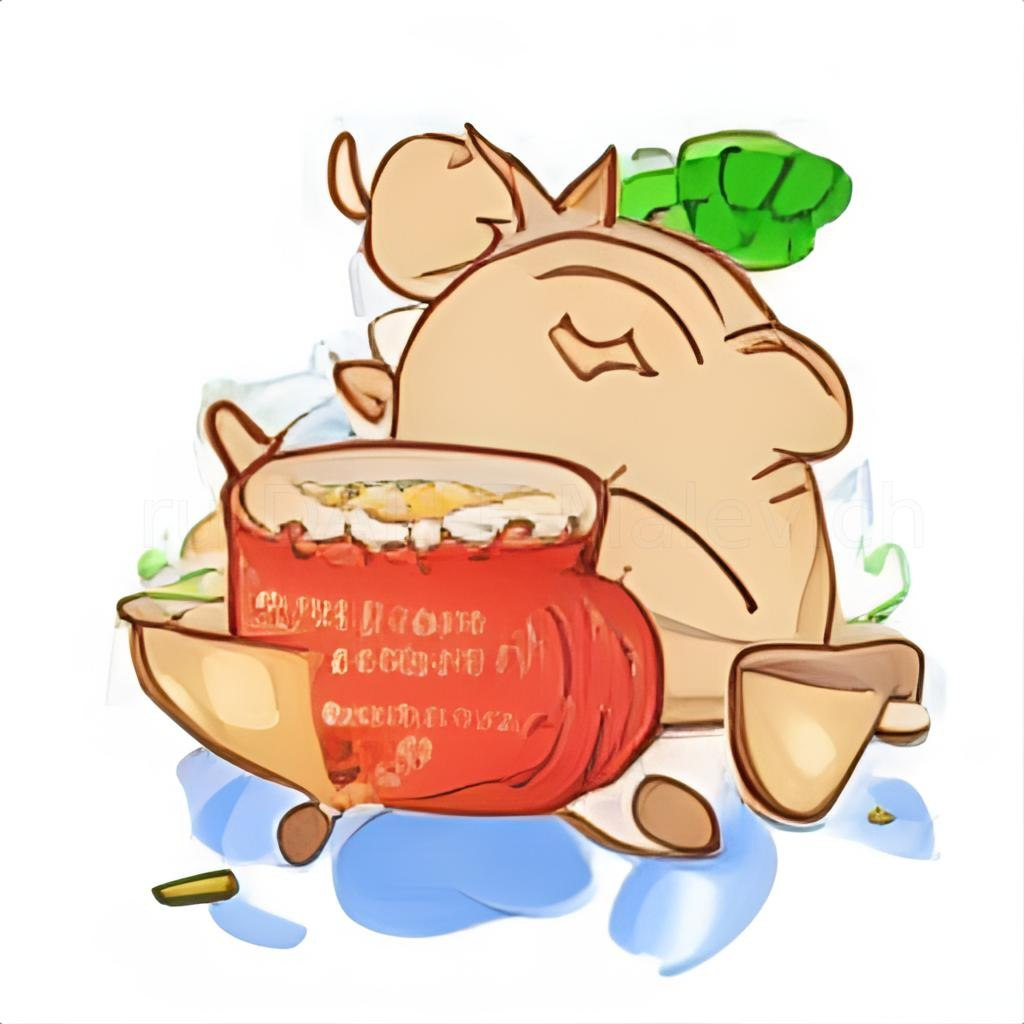

In [ ]:
pip freeze > requirements.txt